# Evaluation of Batch Strategies for One-Class Active Learning

In [1]:
%matplotlib inline
import os
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ternary
sns.set(style="whitegrid")
font_scale=2.2
sns.set_context("notebook", font_scale=font_scale)
plt.rcParams['figure.figsize'] = (10,10)
# Set "True" to output tables in tex-style
print_latex = False
nan = np.nan

Helper functions

In [2]:
def pretty_plot(title="Plot", f=sns.catplot, plot_size=(12, 5), pretty_order=None, pretty_hue_order=None, **kwargs):
    if 'hue' in kwargs:
        kwargs['hue_order'] = pretty_hue_order if pretty_hue_order is not None else order.get(kwargs['hue'])
        if kwargs['hue_order'] is None:
            kwargs['hue_order'] = sorted(kwargs['data'][kwargs['hue']].unique())
    if 'x' in kwargs and f != sns.scatterplot and f != sns.pointplot:
        kwargs['order'] = pretty_order if pretty_order is not None else order.get(kwargs['x'])
        if kwargs['order'] is None:
            kwargs['order'] = sorted(kwargs['data'][kwargs['x']].unique())
    fig, ax = plt.subplots()
    _ = fig.set_size_inches(plot_size)
    g = f(ax=ax, **kwargs)
    if type(g) == sns.axisgrid.FacetGrid:
        plt.close(g.fig)
        ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    return fig

In [3]:
def highlight_max(data, color='gray'):
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

In [4]:
short_names = {
    'RandomPQs': 'rand-S',
    'RandomOutlierPQs': 'rand-o',
    'DecisionBoundaryPQs': 'DB',
    'HighConfidencePQs': 'HC',
    'NeighborhoodBasedPQs': 'NB',
    'BoundaryNeighborCombinationPQs': 'BNC',
    'RandomBatchQs': 'rand-B',
    'TopKBatchQs': 'TopK',
    'GappedTopKBatchQs': 'RandTopK',
    'IterativeBatchQs': 'Iterative',
    'ClusterBatchQs': 'Cluster',
    'ClusterTopKBatchQs': 'ClusterTopK',
    'EnsembleBatchQs': 'Ensemble',
    'FilterSimilarBatchQs': 'FilterSim',
    'FilterHierarchicalBatchQs': 'FilterHrch'
}

order = {
    'query_strategy': short_names.values(),
    'data_set': ["ALOI", "Annthyroid", "Arrhythmia", "Cardiotocography", "Glass",
             "HeartDisease", "Hepatitis", "Ionosphere", "KDDCup99", "Lymphography",
             "PageBlocks", "Parkinson", "PenDigits", "Pima", "Shuttle", "SpamBase",
             "Stamps", "WBC", "WDBC", "WPBC", "Waveform"],
    'k': [1, 2, 4, 8, 16, 32, 64, 128],
}


In [5]:
data_root = "../data/output"
plot_output_path = 'plots/'
scenario_files = [os.path.join(data_root, x) for x in sorted(os.listdir(data_root)) if "summary_data" in x]

In [6]:
scenario_files

['../data/output/summary_data_baseline.csv',
 '../data/output/summary_data_filter.csv',
 '../data/output/summary_data_iterative.csv',
 '../data/output/summary_data_partition.csv']

In [7]:
df = []
for s in scenario_files:
    d = pd.read_csv(s)
    scenario = os.path.basename(scenario_files[1]).replace("summary_data_", "").split(".")[0]
    d.insert(loc=1, column='scenario', value=os.path.basename(s).replace("summary_data_", "").replace("noisy_oracle_", "").split(".")[0])
    df.append(d)
df = pd.concat(df)

Remove the PenDigits data set because Campos did not normalize it despite specifying so in the file name.

In [8]:
df = df.query('data_set_name != "PenDigits"')
df.replace(short_names, inplace=True)

In [9]:
df_success = df.query('exit_code == "success"').reset_index(drop=True)

In [10]:
df.groupby('exit_code').count()[['id']]

,id
exit_code,
ErrorException,487
KDEException,3072
success,70722


Some experiments errored due to a failed KDE. The ErrorExceptions are from infeasible optimization problems with the *Ensemble* strategy for $k \geq 16$.

In [11]:
f"Total experiment run time: {str(datetime.timedelta(seconds=np.sum(df.time_exp)))}."

'Total experiment run time: 311 days, 4:46:16.914023.'

# Criteria interaction

In [12]:
def plot_ternary_criteria_interaction(df, k, inf='DB', div='AngleDiversity'):
    convert_to_weights = lambda x: x / (d[['l_inf', 'l_rep', 'l_div']].sum(axis=1)) * 100

    d = df_success.query('scenario == "iterative" and k == @k and diversity == @div and informativeness == @inf')
    d = d.groupby(['l_inf', 'l_rep', 'l_div']).median()[['end_quality']].reset_index()
    d[['l_inf', 'l_rep', 'l_div']] = d[['l_inf', 'l_rep', 'l_div']].apply(convert_to_weights)
    data = {(a, b, c): d for a, b, c, d in d.values}
    fig, tax = ternary.figure(scale=100)
    fig.set_size_inches((10, 7))
    tax.scatter(list(data.keys()), c=list(data.values()), cmap=plt.cm.Spectral_r, s=600,
                colorbar=True, colormap=plt.cm.Spectral_r,
                cb_kwargs={"shrink": 0.5, 'pad': 0.1})
    fig.axes[1].set_ylabel('Median End Quality', labelpad=15)
    tax.boundary()
    tax.left_axis_label("Informativeness weight in %", offset=0.185, fontsize=28)
    tax.right_axis_label("Representativeness weight in %", offset=0.185, fontsize=28)
    tax.bottom_axis_label("Diversity weight in %", offset=0.185, fontsize=28)
    tax.ticks(axis='lbr', linewidth=1, multiple=20, offset=0.03, fontsize=22)
    tax.get_axes().axis('off')
    tax.clear_matplotlib_ticks()
    tax = tax._redraw_labels()
    fig.tight_layout()
    d[['l_inf', 'l_rep', 'l_div']] = d[['l_inf', 'l_rep', 'l_div']].round({'l_inf': 0, 'l_rep': 0, 'l_div': 0}).astype(int)
    d = d.sort_values('end_quality', ascending=False).round({'end_quality': 4}).reset_index(drop=True)
    return fig, d

### Kernel Angle Diversity

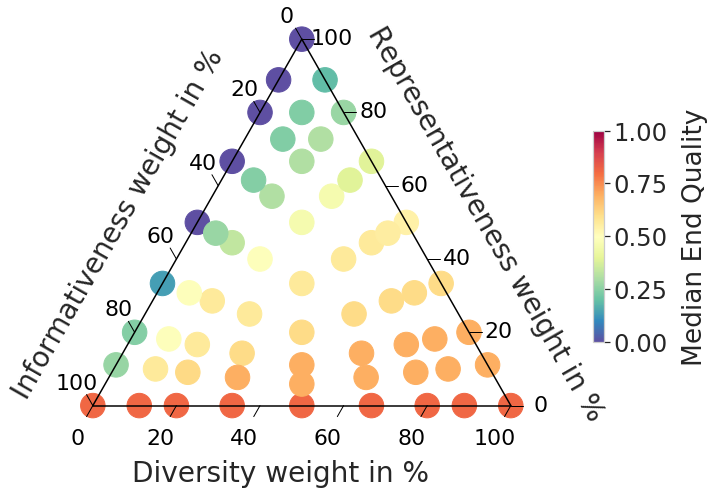

In [13]:
f, d = plot_ternary_criteria_interaction(df_success, 2, 'DB', 'AngleDiversity');
f.savefig(f'{plot_output_path}/criteria_interaction_k=4_DB_AK.pdf')

In [14]:
d.head(10)

,l_inf,l_rep,l_div,end_quality
0,0,0,100,0.8094
1,100,0,0,0.8094
2,80,0,20,0.8094
3,67,0,33,0.8094
4,89,0,11,0.8094
5,11,0,89,0.8094
6,33,0,67,0.8094
7,50,0,50,0.8094
8,20,0,80,0.8094
9,89,11,0,0.6980


### Euclidean Distance

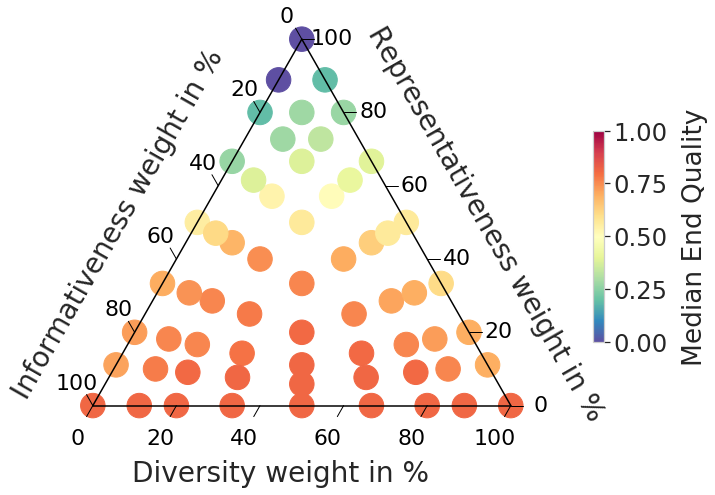

In [15]:
f, d = plot_ternary_criteria_interaction(df_success, 4, 'DB', 'EuclideanDistance');
f.savefig(f'{plot_output_path}/criteria_interaction_k=4_DB_ED.pdf')

In [16]:
d.head(10)

,l_inf,l_rep,l_div,end_quality
0,0,0,100,0.8094
1,100,0,0,0.8094
2,89,0,11,0.8094
3,80,0,20,0.8094
4,31,8,62,0.8094
5,20,0,80,0.8094
6,33,0,67,0.8094
7,50,0,50,0.8094
8,11,0,89,0.8094
9,62,8,31,0.8094


The diversity criterion AK performs slightly better than ED.

In [17]:
k = 4
div = 'AngleDiversity'
inf = 'DB'
convert_to_weights = lambda x: x / (d[['l_inf', 'l_rep', 'l_div']].sum(axis=1)) * 100

d = df_success.query('scenario == "iterative" and k == @k and diversity == @div and informativeness == @inf')
d = d.groupby(['data_set_name', 'l_inf', 'l_rep', 'l_div']).median()[['end_quality']].reset_index()
d[['l_inf', 'l_rep', 'l_div']] = d[['l_inf', 'l_rep', 'l_div']].apply(convert_to_weights)
d[['l_inf', 'l_rep', 'l_div']] = d[['l_inf', 'l_rep', 'l_div']].round({'l_inf': 0, 'l_rep': 0, 'l_div': 0}).astype(int)
d = d.sort_values('end_quality', ascending=False).round({'end_quality': 4}).reset_index(drop=True)
d.groupby('data_set_name').head(1).sort_values(['data_set_name', 'end_quality'], ascending=[True, False]).reset_index(drop=True)

,data_set_name,l_inf,l_rep,l_div,end_quality
0,ALOI,100,0,0,0.4804
1,Annthyroid,44,11,44,0.4597
2,Cardiotocography,80,0,20,0.7533
3,Glass,0,0,100,1.0000
4,HeartDisease,33,67,0,0.7605
5,Hepatitis,9,73,18,0.5675
6,Ionosphere,50,25,25,1.0000
7,KDDCup99,67,0,33,0.9788
8,Lymphography,50,0,50,0.8094
9,PageBlocks,89,0,11,0.8898


Overall a combination of high informativeness and diversity yields the best results.
For some data sets, e.g., HeartDisease or WPBC, including representativeness helps to improve the results.

# Batch Query Strategy Performance

In [18]:
df.query('exit_code == "KDEException"').groupby(['data_set_name', 'query_strategy', 'exit_code'])[['id']].count()

id
data_set_name query_strategy exit_code         
Arrhythmia    FilterHrch     KDEException   144
              Iterative      KDEException  2928

In [19]:
df.query('exit_code == "ErrorException"').groupby(['k', 'query_strategy', 'exit_code'])[['id']].count()

,,,id
k,query_strategy,exit_code,
1,Ensemble,ErrorException,1
32,Ensemble,ErrorException,171
64,Ensemble,ErrorException,162
128,Ensemble,ErrorException,153


The kernel density estimation of the *Iterative* strategy fails several times on the Arrhythmia data set. We therefore exclude the data set for further analysis.
Additionally, *Ensemble* fails to fit the classifiers for batch sizes bigger than 16 on most data sets. We therefore ignore the results of *Ensemble* with batch size $k \geq$ 32.

In [20]:
target_strategies = ['DB', 'rand-B', 'TopK', 'Cluster', 'ClusterTopK', 'Ensemble', 'FilterSim', 'FilterHrch']
df_part2 = df_success.query('data_set_name != "Arrhythmia" and query_strategy in @target_strategies and informativeness in ["DB", @nan] and diversity in ["AngleDiversity", @nan]')
df_part2_prune_ensemble = df_part2.query('query_strategy != "Ensemble" or k <= 16')

In [21]:
res = df_part2_prune_ensemble.groupby(['k', 'data_set_name', 'query_strategy']).median()[['end_quality']]
res = res.unstack('query_strategy')
res = res.T.reset_index(level=0, drop=True).T
res = res.reset_index().round(decimals=2)
res = res.rename(columns={'DB': 'Sequential'})
res = res[['k', 'data_set_name'] + list(x for x in short_names.values() if x in res.columns) + ['Sequential']]

print(res.to_latex(escape=False, na_rep='-', index=False)) if print_latex else res.set_index(['k', 'data_set_name']).style.apply(highlight_max, axis=1)

Median EQ.

In [22]:
res = df_part2_prune_ensemble.groupby(['query_strategy', 'k']).median()[['end_quality']].reset_index().pivot(index='k', columns='query_strategy')
res = res.T.reset_index(level=0, drop=True).T
res = res.reset_index().round(decimals=2)
res = res.rename(columns={'DB': 'Sequential'})
res = res[['k'] + list(x for x in short_names.values() if x in res.columns) + ['Sequential']]
print(res.to_latex(escape=False, na_rep='-', index=False)) if print_latex else res.set_index('k').style.apply(highlight_max, axis=1)

query_strategy,rand-B,TopK,Cluster,ClusterTopK,Ensemble,FilterSim,FilterHrch,Sequential
k,,,,,,,,
1,0.49,0.81,0,0.7,0.81,0.7,0,0.81
2,0.43,0.81,0.28,0.81,0.81,0.81,0.64,nan
4,0.49,0.81,0.35,0.79,0.81,0.79,0.78,nan
8,0.49,0.81,0.54,0.76,0.81,0.78,0.79,nan
16,0.49,0.8,0.57,0.68,0.8,0.78,0.77,nan
32,0.49,0.79,0.6,0.62,nan,0.75,0.75,nan
64,0.49,0.79,0.57,0.6,nan,0.7,0.74,nan
128,0.49,0.75,0.57,0.57,nan,0.7,0.71,nan


Compute number of wins for varying batch size between the batch query strategies.

In [23]:
def compute_num_wins(d, k, metric='end_quality'):
    res = d.query('k == @k')
    res = res.groupby(['data_set_name', 'query_strategy'])[[metric]].mean().reset_index()
    res = res.pivot(index='data_set_name', columns = 'query_strategy')[[metric]]
    res = res.T.reset_index(level=0, drop=True).T
    res = res[[x for x in order['query_strategy'] if x in res.columns]].round(decimals=2)
    return res.apply(lambda x: x == x.max(), axis=1).sum()

In [24]:
data = {k: compute_num_wins(df_part2, k, metric='end_quality') for k in order['k'][1:]}
res = pd.DataFrame(data).transpose()
res.index.rename('k', inplace=True)
res

query_strategy,rand-B,TopK,Cluster,ClusterTopK,Ensemble,FilterSim,FilterHrch
k,,,,,,,
2,4,16,3,9,16,7,5
4,4,16,4,8,16,12,8
8,3,16,5,7,16,10,9
16,3,18,4,5,18,8,9
32,4,18,6,6,1,7,8
64,5,18,5,5,2,7,8
128,4,15,7,5,3,6,8


Average rank

In [25]:
metric = 'end_quality'
res = df_part2.query('k > 1 and query_strategy != "Ensemble"')
res = res.groupby(['data_set_name', 'k', 'query_strategy'])[[metric]].mean().reset_index()
res = res.groupby(['data_set_name', 'k', 'query_strategy'])[[metric]].mean().unstack('query_strategy')
res.rank(axis=1, ascending=False).mean().round(2)

             query_strategy
end_quality  Cluster           4.72
             ClusterTopK       3.42
             FilterHrch        2.98
             FilterSim         2.79
             TopK              1.99
             rand-B            5.10
dtype: float64

### Implicit Diversity

In [26]:
res = df_success.query('k > 1 and k < 32 and query_strategy != "Iterative" and diversity != "AngleDiversity"')
res2 = df_success.query('k > 1 and k < 32 and query_strategy == "Iterative" and diversity == "EuclideanDistance" and l_inf == 0 and l_rep == 0').reset_index(drop=True)
res2['query_strategy'] = "Iterative - Only Div"
res = pd.concat([res, res2])
res = res.query('k in [4, 16]')
res.groupby(['k', 'query_strategy'])[['euclidean_batch_diversity']].agg(['mean', 'std', 'median']).round(2)

euclidean_batch_diversity              
                                             mean    std median
k  query_strategy                                              
4  Cluster                                  19.90  15.36  16.11
   ClusterTopK                              27.54  19.45  25.82
   Ensemble                                 23.66  19.32  21.29
   FilterHrch                               30.85  15.35  29.06
   FilterSim                                33.16  22.42  28.20
   Iterative - Only Div                     31.09  16.35  29.14
   RandTopK                                 20.96  18.43  18.08
   TopK                                     20.56  18.42  17.34
   rand-B                                   17.21  16.33  12.39
16 Cluster                                   2.58   2.86   1.52
   ClusterTopK                               3.38   3.00   2.92
   Ensemble                                  3.30   3.91   2.79
   FilterHrch                                5.09   2.78   5.03
   FilterSim                                 5.56   4.63   5.01
   Iterative - Only Div                      4.98   2.86   4.77
   RandTopK                                  2.73   3.39   1.68
   TopK                                      2.76   3.58   1.76
   rand-B                                    2.16   2.89   1.25

In [27]:
res = df_success.query('k > 1 and k < 32 and query_strategy != "Iterative" and diversity != "EuclideanDistance"')
res2 = df_success.query('k > 1 and k < 32 and query_strategy == "Iterative" and diversity == "AngleDiversity" and l_inf == 0 and l_rep == 0').reset_index(drop=True)
res2['query_strategy'] = "Iterative - Only Div"
res = pd.concat([res, res2])
res = res.query('k in [4, 16]')
res.groupby(['k', 'query_strategy'])[['angle_batch_diversity']].agg(['mean', 'std', 'median']).round(2)

angle_batch_diversity             
                                         mean   std median
k  query_strategy                                         
4  Cluster                             -10.40  5.42  -8.78
   ClusterTopK                          -6.58  6.42  -3.91
   Ensemble                             -9.78  7.49  -8.47
   FilterHrch                           -4.18  5.38  -0.41
   FilterSim                            -5.05  5.80  -1.20
   Iterative - Only Div                 -4.36  5.56  -0.34
   RandTopK                            -11.74  6.76 -12.11
   TopK                                -12.21  6.90 -12.95
   rand-B                              -14.28  5.49 -14.78
16 Cluster                              -5.57  1.34  -5.83
   ClusterTopK                          -4.14  2.36  -3.99
   Ensemble                             -4.47  1.93  -4.08
   FilterHrch                           -2.15  2.15  -1.38
   FilterSim                            -2.44  2.20  -2.25
   Iterative - Only Div                 -2.15  2.16  -1.62
   RandTopK                             -5.31  1.93  -5.70
   TopK                                 -5.32  1.93  -5.76
   rand-B                               -6.20  1.48  -6.53

In terms of euclidean batch diversity, *Iterative* that only uses the diversity criterion produces a batch that is less diverse than from some other strategies. The filter based approaches (*FilterSim* and *FilterHrch*) produce a more diverse batch.
A reason may be the initialization of the batch with a random observation with *Iterative*. This could bound the maximally reachable diversity.

Comparison of different sequential strategies with *TopK*.

In [28]:
df_success.query('query_strategy == "TopK"').groupby(['query_strategy', 'informativeness'])[['end_quality', 'euclidean_batch_diversity', 'angle_batch_diversity']].median()

end_quality  euclidean_batch_diversity  \
query_strategy informativeness                                           
TopK           BNC                 0.645131                   0.912403   
               DB                  0.809427                   1.462714   
               HC                  0.809427                   1.462714   
               NB                  0.790695                   1.330668   
               rand-S              0.567480                   0.736154   
               rand-o              0.697953                   0.775922   

                                angle_batch_diversity  
query_strategy informativeness                         
TopK           BNC                          -3.825170  
               DB                           -1.999020  
               HC                           -1.999221  
               NB                           -2.400844  
               rand-S                       -3.868195  
               rand-o                       -3.860465

Overall DB and HC yield the best results. Diversity of BNC and rand is lower than for other sequential strategies with the *TopK* strategy.

# Runtime

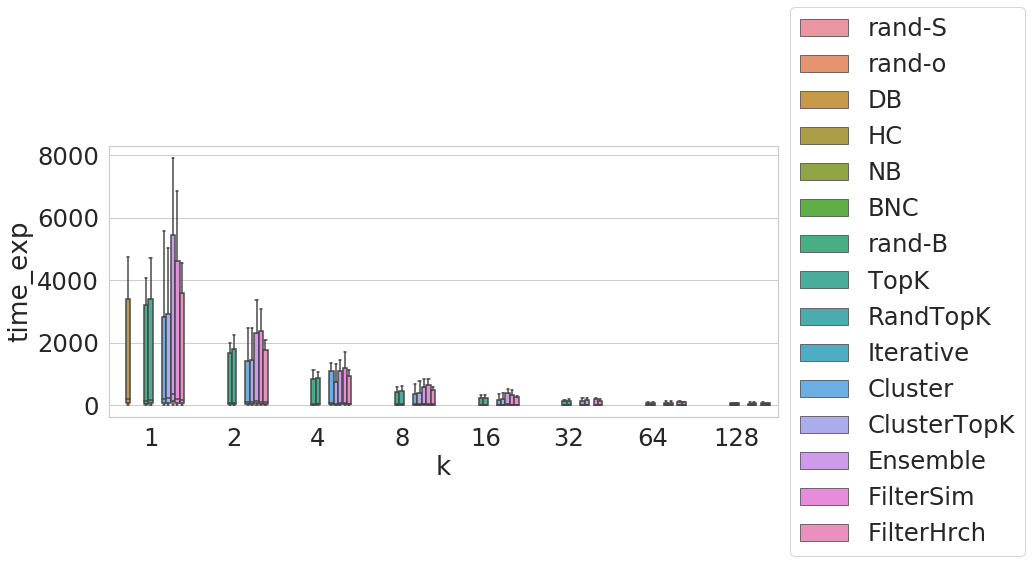

In [29]:
f = pretty_plot(x="k",
                y="time_exp",
                hue="query_strategy",
                data=df_part2_prune_ensemble,
                kind='box')

In [30]:
t_exp = df_part2_prune_ensemble.groupby(['query_strategy', 'k']).median()[['time_exp']].reset_index().pivot(index='k', columns='query_strategy')
t_exp = t_exp.T.reset_index(level=0, drop=True).T
t_exp = t_exp.reset_index().round(decimals=2)
t_exp = t_exp.rename(columns={'DB': 'Sequential'})
t_exp = t_exp[['k'] + list(x for x in short_names.values() if x in t_exp.columns) + ['Sequential']]
print(t_exp.to_latex(escape=False, na_rep='-', index=False)) if print_latex else t_exp

query_strategy,k,rand-B,TopK,Cluster,ClusterTopK,Ensemble,FilterSim,FilterHrch,Sequential
0,1,128.95,158.07,179.27,213.14,343.61,180.25,157.89,177.93
1,2,69.80,70.55,99.11,79.46,117.42,98.90,92.56,NaN
2,4,41.04,44.52,58.39,44.14,53.01,54.94,40.31,NaN
3,8,18.29,23.58,22.56,18.54,34.76,21.82,23.04,NaN
4,16,9.55,12.36,13.34,14.41,24.77,14.27,12.38,NaN
5,32,6.20,5.41,6.98,5.74,NaN,8.06,5.69,NaN
6,64,3.44,3.70,3.30,4.01,NaN,4.28,3.55,NaN
7,128,2.36,2.20,2.63,3.09,NaN,2.83,2.96,NaN


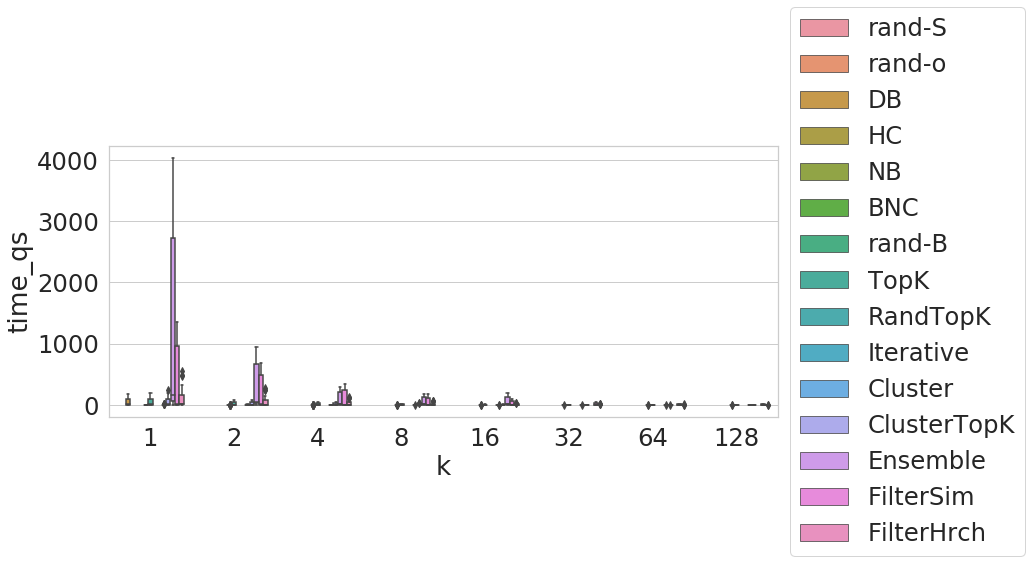

In [31]:
f = pretty_plot(x="k",
                y="time_qs",
                hue="query_strategy",
                data=df_part2_prune_ensemble,
                kind='box')

In [32]:
t_qs = df_part2_prune_ensemble.groupby(['query_strategy', 'k']).median()[['time_qs']].reset_index().pivot(index='k', columns='query_strategy')
t_qs = t_qs.T.reset_index(level=0, drop=True).T
t_qs = t_qs.reset_index().round(decimals=2)
t_qs = t_qs.rename(columns={'DB': 'Sequential'})
t_qs = t_qs[['k'] + list(x for x in short_names.values() if x in t_qs.columns) + ['Sequential']]
print(t_qs.to_latex(escape=False, na_rep='-', index=False)) if print_latex else t_qs

query_strategy,k,rand-B,TopK,Cluster,ClusterTopK,Ensemble,FilterSim,FilterHrch,Sequential
0,1,0.12,10.63,3.37,13.35,169.08,22.33,21.22,10.5
1,2,0.04,4.35,1.81,4.28,40.80,10.19,6.97,NaN
2,4,0.02,2.34,0.15,2.61,18.15,6.05,3.68,NaN
3,8,0.01,1.20,0.03,1.32,15.96,2.40,1.71,NaN
4,16,0.00,0.62,0.03,0.83,14.77,1.48,0.82,NaN
5,32,0.00,0.29,0.01,0.35,NaN,1.08,0.50,NaN
6,64,0.00,0.13,0.01,0.19,NaN,0.47,0.20,NaN
7,128,0.00,0.08,0.01,0.09,NaN,0.22,0.19,NaN


In [33]:
t_comb = t_exp.iloc[:, 1:].astype(str) + ' / '+ t_qs.iloc[:, 1:].astype(str)
t_comb.replace({'nan / nan': '-'}, inplace=True)
t_comb.insert(0, 'k', order['k'])
print(t_comb.to_latex(escape=False, index=False)) if print_latex else t_comb

query_strategy,k,rand-B,TopK,Cluster,ClusterTopK,Ensemble,FilterSim,FilterHrch,Sequential
0,1,128.95 / 0.12,158.07 / 10.63,179.27 / 3.37,213.14 / 13.35,343.61 / 169.08,180.25 / 22.33,157.89 / 21.22,177.93 / 10.5
1,2,69.8 / 0.04,70.55 / 4.35,99.11 / 1.81,79.46 / 4.28,117.42 / 40.8,98.9 / 10.19,92.56 / 6.97,-
2,4,41.04 / 0.02,44.52 / 2.34,58.39 / 0.15,44.14 / 2.61,53.01 / 18.15,54.94 / 6.05,40.31 / 3.68,-
3,8,18.29 / 0.01,23.58 / 1.2,22.56 / 0.03,18.54 / 1.32,34.76 / 15.96,21.82 / 2.4,23.04 / 1.71,-
4,16,9.55 / 0.0,12.36 / 0.62,13.34 / 0.03,14.41 / 0.83,24.77 / 14.77,14.27 / 1.48,12.38 / 0.82,-
5,32,6.2 / 0.0,5.41 / 0.29,6.98 / 0.01,5.74 / 0.35,-,8.06 / 1.08,5.69 / 0.5,-
6,64,3.44 / 0.0,3.7 / 0.13,3.3 / 0.01,4.01 / 0.19,-,4.28 / 0.47,3.55 / 0.2,-
7,128,2.36 / 0.0,2.2 / 0.08,2.63 / 0.01,3.09 / 0.09,-,2.83 / 0.22,2.96 / 0.19,-


Time in seconds and ratio of time spend for query selection in %:

In [34]:
t_comb = t_exp.iloc[:, 1:].apply(np.round).astype("Int64").astype(str) + 's/'+ (t_qs.iloc[:, 1:] / t_exp.iloc[:, 1:] * 100).round(1).astype(str) + '%'
t_comb.replace({'nans/nan%': '-'}, inplace=True)
t_comb.insert(0, 'k', order['k'])
# minified version:
#print(t_comb.iloc[:, [0, 1, 2, 4, 5, 6, 7]].replace({'%': '\%'}, regex=True).to_latex(escape=False, index=False)) if print_latex else t_comb
print(t_comb.replace({'%': '\%'}, regex=True).to_latex(escape=False, index=False)) if print_latex else t_comb

query_strategy,k,rand-B,TopK,Cluster,ClusterTopK,Ensemble,FilterSim,FilterHrch,Sequential
0,1,129s/0.1%,158s/6.7%,179s/1.9%,213s/6.3%,344s/49.2%,180s/12.4%,158s/13.4%,178s/5.9%
1,2,70s/0.1%,71s/6.2%,99s/1.8%,79s/5.4%,117s/34.7%,99s/10.3%,93s/7.5%,-
2,4,41s/0.0%,45s/5.3%,58s/0.3%,44s/5.9%,53s/34.2%,55s/11.0%,40s/9.1%,-
3,8,18s/0.1%,24s/5.1%,23s/0.1%,19s/7.1%,35s/45.9%,22s/11.0%,23s/7.4%,-
4,16,10s/0.0%,12s/5.0%,13s/0.2%,14s/5.8%,25s/59.6%,14s/10.4%,12s/6.6%,-
5,32,6s/0.0%,5s/5.4%,7s/0.1%,6s/6.1%,-,8s/13.4%,6s/8.8%,-
6,64,3s/0.0%,4s/3.5%,3s/0.3%,4s/4.7%,-,4s/11.0%,4s/5.6%,-
7,128,2s/0.0%,2s/3.6%,3s/0.4%,3s/2.9%,-,3s/7.8%,3s/6.4%,-
